In [1]:
import pickle
import numpy as np
import random
random.seed(666)
####################################################################################################
# The datafiles are here: mint.uvt.nl:/roaming/gchrupal/vgs/experiments/flickr8k-segmatch_s3_grl-3/
####################################################################################################

# Load validation sentence data
sent = pickle.load(open("val_sentences.pkl", "rb"))
# Load validation embeddings
emb  = np.load("val_embeddings.npy")

# Shuffle
ix = list(range(len(sent)))
random.shuffle(ix)
sent = [ sent[i] for i in ix]
emb  = emb[np.array(ix)]

You need to install vg in order to run the cell below.

```
git clone git@github.com:gchrupala/vgs.git
cd vgs
python3 setup.py develop --user
```

In [2]:
# Compute scores for paraphrase retrieval
from vg.evaluate import paraphrase_ranking
N = len(sent)
correct = np.zeros((N, N)).astype(bool)

In [3]:
for i in range(N):
    for j in range(N):
        if sent[i]['imgid'] == sent[j]['imgid'] and i != j:
                correct[i, j] = True

In [4]:
result = paraphrase_ranking(emb, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 20.0
Recall @ 10: 0.1263


In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X = pca.fit_transform(emb)
print(pca.explained_variance_)

[0.6780892  0.09926847]


In [6]:
# Results for just the 2D projected embeddings
result = paraphrase_ranking(X, correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 10.0
Recall @ 10: 0.20775


In [7]:
# Results for just the first PC
result = paraphrase_ranking(X[:,:1], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 536.5
Recall @ 10: 0.0038


In [8]:
# Results for just the second PC
result = paraphrase_ranking(X[:,1:], correct)
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 796.0
Recall @ 10: 0.0019


In [9]:
# Hmm maybe we need euclidean with just a single dim
print("PC1")
result = paraphrase_ranking(X[:,0:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))
print("PC2")
result = paraphrase_ranking(X[:,1:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))
print("PC1 PC2")
result = paraphrase_ranking(X[:,:], correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))


PC1
Median rank: 10.0
Recall @ 10: 0.21705
PC2
Median rank: 25.0
Recall @ 10: 0.09165
PC1 PC2
Median rank: 10.0
Recall @ 10: 0.21705


In [10]:
%pylab inline --no-import-all

Populating the interactive namespace from numpy and matplotlib


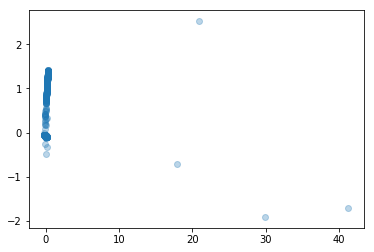

In [11]:
# What does the PCA space look like

pylab.scatter(X[:, 0], X[:,1], alpha=0.3)

In [12]:
# The retrieval scores are pretty decent
# Let's see some nearest neighbors
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X)
for i in range(0, 1000, 200):
    count = Counter()
    print(sent[i]['raw'])
    for k in range(1, 15):
        j = sim[i].argsort()[-k]
        if i != j:
            print(correct[i][j], sent[j]['imgid'], sent[j]['speaker'], sim[i,j], sent[j]['raw'])
            count.update([sent[j]['imgid']])
    print(count)
    print()
    

A bride folds her arms at a beach .
True 6977 flickr8k_66 0.99999994 A girl wears a fancy dress and a tiara .
False 6978 flickr8k_17 0.9999998 A man in red rock climbing .
False 6978 flickr8k_11 0.99999976 Someone climbing a rock upside down
True 6977 flickr8k_21 0.9999997 a woman wear a fancy dress and tiara on a beach
False 6978 flickr8k_49 0.99999964 Men try to climb up a large rock .
False 6978 flickr8k_4 0.9999995 Two men are climbing on an interestingly shaped rock feature .
False 6976 flickr8k_92 0.9999993 A young girl in a striped shirt wears a bowl on her head .
False 6976 flickr8k_9 0.99999905 A little girl smiles as she wears a white bowl on the top of her head .
False 6976 flickr8k_111 0.9999977 A young girl sitting at a table with a bowl on her head
False 6979 flickr8k_91 0.99999714 A man poses for a little girl , his arms outstretched , with a large church in the background .
False 6978 flickr8k_5 0.9999932 A person in a red shirt is holding on to a natural formation .
Fa

In [13]:
# How correlated are these components with utterance length?
import scipy.stats
L = np.array([s['audio'].shape[0] for s in sent])
print(scipy.stats.pearsonr(X[:,0], L))
print(scipy.stats.pearsonr(X[:,1], L))

(0.06293929663065387, 8.437016492050564e-06)
(0.5302965071000647, 0.0)


In [14]:
# Results for utterance length
result = paraphrase_ranking(L.reshape((len(L), 1)), correct, metric='euclidean')
print("Median rank: {}".format(np.median(result['ranks'])))
print("Recall @ 10: {}".format(np.mean(result['recall'][10])))

Median rank: 749.0
Recall @ 10: 0.0021


In [15]:
# We will pick N random utterances, and compute counts of image ids among 10 nearest neighbors.
from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances

def purity(sim, size=100, seed=123, neighborhood=10):
    random.seed(666)
    maxes = []
    maxes_r = []
    for i in random.sample(range(len(sim)), size):
        count = Counter()
        for k in range(1, neighborhood):
            j = sim[i].argsort()[k]
            count.update([sent[j]['imgid']])
        maxes.append(max(count.values()))
        count = Counter()
        for k in random.sample(range(len(sim)), neighborhood):
            j = k
            count.update([sent[j]['imgid']])
        maxes_r.append(max(count.values()))
    return numpy.array(maxes), numpy.array(maxes_r)

In [17]:
K = 1000
Ms = [5, 10, 20, 40, 80]
print("K M dist space rand neighbor")
for M in Ms: 
    for ndist, dist in [('cos',cosine_distances), ('euc', euclidean_distances)]:
        for nspace, space in [('emb', emb), ('pca', X)]:
            close, rand = purity(dist(space), size=K, neighborhood=M)
            print("{} {} {} {} {} {}".format(K, M, ndist, nspace, numpy.mean(rand), numpy.mean(close)))

K M dist space rand neighbor
1000 5 cos emb 1.007 1.055
1000 5 cos pca 1.007 1.44
1000 5 euc emb 1.007 1.055
1000 5 euc pca 1.007 1.477
1000 10 cos emb 1.043 1.229
1000 10 cos pca 1.043 2.326
1000 10 euc emb 1.043 1.284
1000 10 euc pca 1.043 2.347
1000 20 cos emb 1.144 1.656
1000 20 cos pca 1.144 3.369
1000 20 euc emb 1.144 1.796
1000 20 euc pca 1.144 3.421
1000 40 cos emb 1.469 2.214
1000 40 cos pca 1.469 4.403
1000 40 euc emb 1.469 2.42
1000 40 euc pca 1.469 4.433
1000 80 cos emb 1.975 2.922
1000 80 cos pca 1.975 4.846
1000 80 euc emb 1.975 3.255
1000 80 euc pca 1.975 4.854
